<a href="https://colab.research.google.com/github/rahiakela/data-science-research-and-practice/blob/main/data-science-bookcamp/case-study-5--predicting-future-friendships/04_linear_classifiers_with_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Linear Classifiers with Logistic Regression

In this notebook, we simulated customer heights (in inches) and weights (in pounds). We’ll now proceed to re-run that simulation. 

For the purpose of this exercise, we’ll focus on the two classes; _Large_ and _Not Large_. 

We’ll assume that customers within the _Large_ class are taller than 72 inches and heavier than 160 lb.

##Setup

In [1]:
import re
import glob
import time
import numpy as np
import pandas as pd

from collections import Counter
from collections import defaultdict

from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def plot_customers(X, y, xlabel='Inches (in)', ylabel='Pounds (lb)'):
  colors = ['g', 'y']
  labels = ['Not Large', 'Large']
  for i, (color, label) in enumerate(zip(colors, labels)):
      plt.scatter(X[:,0][y == i], X[:,1][y == i], color=color, label=label)
  
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)

##Dataset

In [7]:
# Simulating Categorized Customer Measurements
np.random.seed(1)

inches = np.arange(60, 78, 0.1)
random_fluctuations = np.random.normal(scale=10, size=inches.size)
pounds = 4 * inches - 130 + random_fluctuations

X = np.array([inches, pounds]).T
y = ((X[:, 0] > 72) & (X[:, 1] > 60)).astype(int)

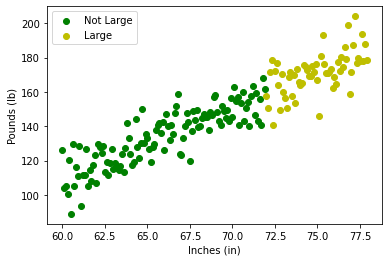

In [8]:
plot_customers(X, y)
plt.legend()
plt.show()

##Linear Classifier

We can image a knife slicing through the cigar-shaped plot, in order to separate the colors. The knife acts like a boundary that separates the two customer classes. 

We can represent this boundary using a line with slope of -3.5 and a y-intercept of 415.

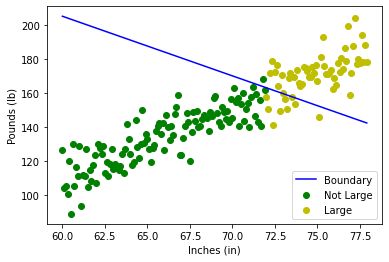

In [9]:
# Plotting a boundary to separate the two customer classes
def boundary(inches):
  return -3.5 * inches + 415

plt.plot(X[:, 0], boundary(X[:, 0]), color="b", label="Boundary")
plot_customers(X, y)
plt.legend()
plt.show()

Most of the customers within the _Large_ class are located above the plotted line. Hence, we can use this line to classify the customers. 

Given a customer with measurement of `(inches, lbs)`, we predict the customer’s class by checking whether `lbs > -3.5 * inches + 415`. 

In [ ]:
# Predicting classes using a linear boundary
np.random.seed(0)

x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.25)
print(f"Training set labels:\n{y_train}")

Training set labels:
[0 2 1 2 1 0 2 0 2 0 0 2 0 2 1 1 1 2 2 1 1 0 1 2 2 0 1 1 1 1 0 0 0 2 1 2 0]


Since the features within the iris dataset can be plotted in multi-dimensional space. This plotted data forms spatial clusters. 

Hence, elements in `X_test` are more likely to share their class with the `X_train` points found in the adjacent cluster. 

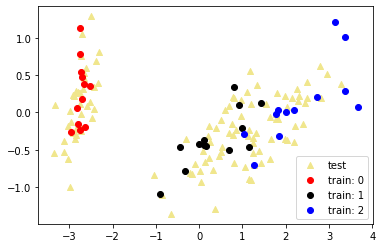

In [ ]:
# Plotting the training and test sets
pca_model = PCA()
transformed_data_2D = pca_model.fit_transform(x_train)

unlabeled_data = pca_model.transform(x_test)

plt.scatter(unlabeled_data[:, 0], unlabeled_data[:, 1], color="khaki", marker="^", label="test")
for label in range(3):
  data_subset = transformed_data_2D[y_train == label]
  plt.scatter(data_subset[:, 0], data_subset[:, 1], color=["r", "k", "b"][label], label=f"train: {label}")
plt.legend()
plt.show()

Many unlabeled points cluster around _Species 0_. These unlabeled flowers clearly belong to the same species. Elsewhere in the plot, certain unlabeled flowers are proximate to both _Species 1_ and _Species 2_. 

For each such point, we'll need to quantify which labeled species are closer. This will require us to track the Euclidean distance between each feature in `X_test` and each feature in `X_train`. 

In [ ]:
# Computing Euclidean distances between points
distance_matrix = euclidean_distances(x_test, x_train)

f_train, f_test = x_test[0], X[0]
distance = distance_matrix[0][0]
print(f"Our first test set feature is {f_train}")
print(f"Our first training set feature is {f_test}")
print(f"The Euclidean distance between the features is {distance:.2f}")

Our first test set feature is [5.8 2.8 5.1 2.4]
Our first training set feature is [5.1 3.5 1.4 0.2]
The Euclidean distance between the features is 4.18


We can assume that each unlabeled point shares a class that is common to its neighbors. 

This strategy forms the basis for the **K-nearest Neighbors** algorithm, which is referred to as **KNN** for short. 

In [ ]:
# Labeling a point based on its nearest neighbors
np.random.seed(6)

random_index = np.random.randint(y_test.size)
labeled_distances = distance_matrix[random_index]
# Sort all data points in the training set based on their distance and Select the top K-nearest neighbors(3) of the point
labeled_neighbors = np.argsort(labeled_distances)[:3]
labels = y_train[labeled_neighbors]

# Pick the most frequently occurring class across the K neighboring points
top_label, count = Counter(labels).most_common()[0]
print(f"The 3 nearest neighbors of Point {random_index} have the following labels:\n{labels}")
print(f"\nThe most common class label is {top_label}. It occurs {count} times.")

The 3 nearest neighbors of Point 10 have the following labels:
[2 1 2]

The most common class label is 2. It occurs 2 times.


The most common class label among the neighbors of _Point 10_ is _Label 2_. 

How does this compare to the actual class of the flower?

In [ ]:
# Checking the true class of a predicted label
true_label = y_test[random_index]
print(f"The true class of Point {random_index} is {true_label}.")

The true class of Point 10 is 2.


We can reformulate KNN as a graph theory problem. We can treat each point as a node, and its label as a node attribute. 

Afterwards, we can choose an unlabeled point and extend edges to its K closest labeled neighbors. Visualizing the neighbor graph subsequently allows us to identify the point.

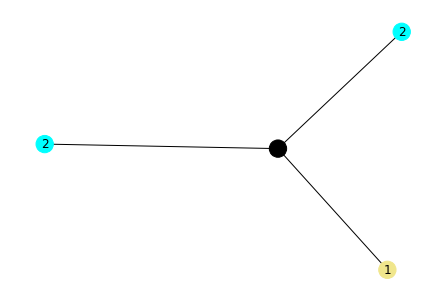

In [ ]:
# Visualizing nearest neighbors with NetworkX
np.random.seed(0)

def generate_neighbor_graph(unlabeled_index, labeled_neighbors):
  G = nx.Graph()
  nodes = [(i, {"label": y_train[i]}) for i in labeled_neighbors]
  nodes.append((unlabeled_index, {"label": "U"}))
  G.add_nodes_from(nodes)
  G.add_edges_from([(i, unlabeled_index) for i in labeled_neighbors])
  labels = y_train[labeled_neighbors]
  label_colors = ["pink", "khaki", "cyan"]
  colors = [label_colors[y_train[i]] for i in labeled_neighbors] + ["k"]
  labels = {i: G.nodes[i]["label"] for i in G.nodes}
  nx.draw(G, node_color=colors, labels=labels, with_labels=True)
  plt.show()
  return G

G = generate_neighbor_graph(random_index, labeled_neighbors)

KNN works when there are just three neighbors. 

What happens if we increase the neighbor count to four?

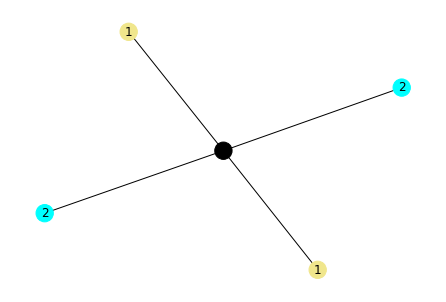

In [ ]:
# Increasing the number of nearest neighbors
np.random.seed(0)

labeled_neighbors = np.argsort(labeled_distances)[:4]
G = generate_neighbor_graph(random_index, labeled_neighbors)

There is a tie! 

We can break that tie by weighing label-votes based on the inverse distance to the unlabeled point.

In [ ]:
# Weighing votes of neighbors based on distance
class_to_votes = defaultdict(int)

for node in G.neighbors(random_index):
  label = G.nodes[node]["label"]
  distance = distance_matrix[random_index][node]
  num_votes = 1 / distance
  print(f"A data point with a label of {label} is {distance:.2f} units away. It receives {num_votes:.2f} votes.")
  class_to_votes[label] += num_votes

print()

for class_label, votes in class_to_votes.items():
  print(f"We counted {votes:.2f} votes for class {class_label}.")

top_class = max(class_to_votes.items(), key=lambda x: x[1])[0]
print(f"Class {top_class} has received the plurality of the votes.")

A data point with a label of 2 is 0.54 units away. It receives 1.86 votes.
A data point with a label of 1 is 0.74 units away. It receives 1.35 votes.
A data point with a label of 2 is 0.77 units away. It receives 1.29 votes.
A data point with a label of 1 is 0.98 units away. It receives 1.02 votes.

We counted 3.15 votes for class 2.
We counted 2.36 votes for class 1.
Class 2 has received the plurality of the votes.


Of course, this improvement
is by no means guaranteed; occasionally, weighted voting can worsen the outputted
results. 

Depending on the preset value of our K, weighted voting can either
improve or worsen our predictions. 

We won’t know for sure until we test prediction
performance across a range of parameters.

##Measuring Accuracy

We want to analyze predictions across all the points within `X_test`. We'll define a `predict` function for this purpose.

In [ ]:
# Parameterizing KNN predictions
def predict(index, K=1, weighted_voting=False):
  labeled_distances = distance_matrix[index]
  labeled_neighbors = np.argsort(labeled_distances)[:K]
  class_to_votes = defaultdict(int)
  for neighbor in labeled_neighbors:
    label = y_train[neighbor]
    distance = distance_matrix[index][neighbor]
    num_votes = 1 / max(distance, 1e-10) if weighted_voting else 1
    class_to_votes[label] += num_votes
  return max(class_to_votes, key=lambda x: class_to_votes[x])

assert predict(random_index, K=3) == 2
assert predict(random_index, K=4, weighted_voting=True) == 2

Lets execute `predict` across all unlabeled indices.

In [ ]:
# Predicting all unlabeled flower classes
y_pred = np.array([predict(i) for i in range(y_test.size)])

We want to compare the predicted classes with the actual classes in `y_test`. 

Lets start by printing out both the `y_pred` and the `y_test` arrays.

In [ ]:
# Comparing the predicted and actual classes
print(f"Predicted Classes:\n{y_pred}")
print(f"\nActual Classes:\n{y_test}")

Predicted Classes:
[2 1 0 2 0 2 0 1 1 1 2 1 1 1 2 0 2 1 0 0 2 1 0 0 2 0 0 1 1 0 2 1 0 2 2 1 0
 2 1 1 2 0 2 0 0 1 2 2 1 2 1 2 1 1 1 1 1 1 1 2 1 0 2 1 1 1 2 2 0 0 2 1 0 0
 1 0 2 1 0 1 2 1 0 2 2 2 2 0 0 2 2 0 2 0 2 2 0 0 2 0 0 0 1 2 2 0 0 0 1 1 0
 0 1]

Actual Classes:
[2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 2 1 0 0 2 0 0 1 1 0 2 1 0 2 2 1 0
 1 1 1 2 0 2 0 0 1 2 2 2 2 1 2 1 1 2 2 2 2 1 2 1 0 2 1 1 1 1 2 0 0 2 1 0 0
 1 0 2 1 0 1 2 1 0 2 2 2 2 0 0 2 2 0 2 0 2 2 0 0 2 0 0 0 1 2 2 0 0 0 1 1 0
 0 1]


It's easier to compare the two arrays if we aggregate them into a **cofusion matrix**.  

The matrix rows will track predicted classes, while the columns will track the true class identities. 

In [ ]:
# Computing the confusion matrix
def compute_confusion_matrix(y_pred, y_test):
  # Checks for the total number of classes. This value defines the number of matrix rows and columns
  num_classes = len(set(y_pred) | set(y_test))
  confusion_matrix = np.zeros((num_classes, num_classes))
  for prediction, actual in zip(y_pred, y_test):
    # For every such pair, we add a 1 to the row Prediction and column Actual of our matrix. 
    # Note that if Prediction == Actual, then the added value appears on the diagonal of the matrix.
    confusion_matrix[prediction][actual] += 1
  return confusion_matrix

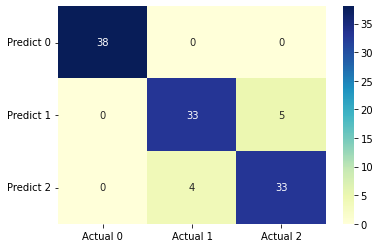

In [ ]:
M = compute_confusion_matrix(y_pred, y_test)
sns.heatmap(M, annot=True, cmap="YlGnBu", 
            yticklabels=[f"Predict {i}" for i in range(3)],
            xticklabels=[f"Actual {i}" for i in range(3)])
plt.yticks(rotation=0)
plt.show()

Each diagonal element `M[i][i]`
tracks the number of accurately predicted instances of Class `i`. Such accurate predictions
are commonly called true positives. 

Based on our displayed diagonal values, we
know that our true positive count is very high. 

Let’s print the total true positive count
by summing across `M.diagonal()`.

In [ ]:
# Counting the number of accurate predictions
num_accurate_predictions = M.diagonal().sum()
print(f"Our results contain {int(num_accurate_predictions)} accurate predictions.")

Our results contain 104 accurate predictions.


The fraction of total accurate predictions is referred to as the **accuracy** score. 

Accuracy can be computed dividing the diagonal sum across the total sum of matrix elements.

In [ ]:
# Measuring the accuracy score
accuracy = M.diagonal().sum() / M.sum()
assert accuracy == 104 / (104 + 9)
print(f"Our predictions are {100 * accuracy:.0f}% accurate.")

Our predictions are 92% accurate.


The model periodically confuses instances of _Classes 1_ and _2_. Lets try to quantify that confusion. 

First, we'll count the total number of elements that we've predicted as belonging to _Class 1_. 

In [ ]:
# Counting the predicted Class 1 elements
row1_sum = M.sum()
print(f"We've predicted that {int(row1_sum)} elements belong to Class 1.")

We've predicted that 113 elements belong to Class 1.


We've predicted that 38 elements belong to _Class 1_. 33 predictions are true positives. Meanwhile, the remaining 5 predictions are **false positives**. 

The ratio `33 / 38` produces a metric called **precision**. A low precision indicates that a predicted class label is not very reliable. 

In [ ]:
# Computing the precision of Class 1
precision = M[1][1] / M[1].sum()
assert precision == 33 / 38
print(f"Precision of Class 1 is {precision:.2f}")

Precision of Class 1 is 0.87


Errors can also be detected across the confusion matrix columns. 

Consider for example, _Column 1_. That column tracks all elements in `y_test` whose true label is equal to _Class 1_.

In [ ]:
# Counting the total Class 1 elements
col1_sum = M[:, 1].sum()
assert col1_sum == y_test[y_test == 1].size
print(f"{int(col1_sum)} elements in our test set belong to Class 1.")

37 elements in our test set belong to Class 1.


37 elements in our test set belong to _Class 1_. 33 of the elements are true positives. The remaining 4 elements are **false negatives**. 

The ratio `33 / 37` produces a metric called **recall**. A low recall indicates that our predictor commonly misses valid instances of a class.

In [ ]:
# Computing the recall of Class 1
recall = M[1][1] / M[:, 1].sum()
assert recall == 33 / 37
print(f"Recall of Class 1 is {recall:.2f}")

Recall of Class 1 is 0.89


A maximum recall of 1.0 is trivial to achieve. We simply need to label each incoming data-point as belonging to _Class 1_. 

However, this will cause precision to drop drastically. 

In [ ]:
# Checking precision at a recall of 1.0
low_precision = M[1][1] / M.sum()
print(f"Precision at a trivially maximized recall is {low_precision:.2f}")

Precision at a trivially maximized recall is 0.29


We should combine precision and recall into a single metric. However, we can't average these values because they are fractions with different denominators. 

Fortunately, their numerators are both equal to `M[1][1]`. Thus, we can invert the fractions and then take their average.

In [ ]:
# Taking the mean of the inverted metrics
inverse_average = (1 / precision + 1 / recall) / 2
print(f"The average of inverted metrics is {inverse_average:.2f}")

The average of inverted metrics is 1.14


The average of the inverses is higher than 1.0. 

However, both precision and recall have a maximum ceiling of 1.0. We can force the aggregated value to fall within that range by taking an inverse of the average.

In [ ]:
# Taking the inverse of the inverted mean
result = 1 / inverse_average
print(f"The inverse of average is {result:.2f}")

The inverse of average is 0.88


Our aggregated metric is called the **f1-measure** or **f1-score**. Commonly, it's referred to as simply the **f-measure**. 

The f-measure can be computed more directly by running `2 * precision * recall / (precision + recall)`.

In [ ]:
# Computing the f-measure of Class 1
f_measure = 2 * precision * recall / (precision + recall)
print(f"The f-measure of Class 1 is {precision:.2f}")

The f-measure of Class 1 is 0.87


In this instance, the f-measure is equal to the average of the precision and recall. However this is not always the case. 

Consider a prediction that has one true positive, one false positive, and zero false negatives. 

In [ ]:
# Comparing the f-measure to the average
tp, fp, fn = 1, 1, 0

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f_measure = 2 * precision * recall / (precision + recall)
average = (precision + recall) / 2

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Average: {average}")
print(f"F-measure: {f_measure:.2f}")

Precision: 0.5
Recall: 1.0
Average: 0.75
F-measure: 0.67


The f-measure provides us with a robust evaluation for an individual class. 

With this in mind, we'll now compute the f-measure for each class within our dataset.

In [ ]:
# Computing the f-measure for each class
def compute_f_measures(M):
  precisions = M.diagonal() / M.sum(axis=0)
  recalls = M.diagonal() / M.sum(axis=1)
  return 2 * precisions * recalls / (precisions + recalls)

f_measures = compute_f_measures(M)
for class_label, f_measure in enumerate(f_measures):
  print(f"The f-measure for Class {class_label} is {f_measure:.2f}")

The f-measure for Class 0 is 1.00
The f-measure for Class 1 is 0.88
The f-measure for Class 2 is 0.88


We computed three f-measures across three different classes. These f-measures can be combined into a single score by taking their mean.

In [ ]:
# Computing the f-measure for each class
avg_f = f_measures.mean()
print(f"Our unified f-measure equals {avg_f:.2f}")

Our unified f-measure equals 0.92


The f-measure is identical to our accuracy. However, that f-measure and accuracy are not guaranteed to be the same. 

The difference between the metrics is especially noticeable when the classes are **imbalanced**. In an imbalanced dataset, there are way more instances of some _Class A_ than of another _Class B_.

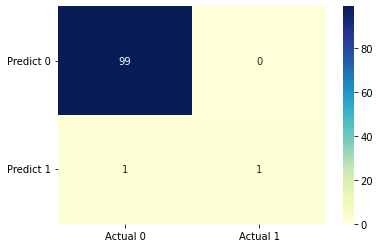

In [ ]:
# Comparing performance metrics across imbalanced data
M_imbalanced = np.array([[99, 0], [1, 1]])
sns.heatmap(M_imbalanced, annot=True, cmap="YlGnBu", 
            yticklabels=[f"Predict {i}" for i in range(2)],
            xticklabels=[f"Actual {i}" for i in range(2)])
plt.yticks(rotation=0)
plt.show()

In [ ]:
accuracy_imb = M_imbalanced.diagonal().sum() / M_imbalanced.sum()
f_measure_imb = compute_f_measures(M_imbalanced).mean()

print(f"The accuracy for our imbalanced dataset is {accuracy_imb:.2f}")
print(f"The f-measure for our imbalanced dataset is {f_measure_imb:.2f}")

The accuracy for our imbalanced dataset is 0.99
The f-measure for our imbalanced dataset is 0.83


Generally, the f-measure is considered a superior prediction metric due to its sensitivity
to imbalance.

All the prediction metrics that we've discussed thus far are available in Scikit-Learn. 

For instance, we can compute the confusion matrix by importing and running `confusion_matrix`.

In [ ]:
# Computing the confusion matrix using Scikit-Learn
M2 = confusion_matrix(y_pred, y_test)
assert np.array_equal(M, M2)
print(M2)

[[38  0  0]
 [ 0 33  5]
 [ 0  4 33]]


In that same manner, we can compute the accuracy by importing and running `accuracy_score`.

In [ ]:
# Computing the accuracy using Scikit-Learn
assert accuracy_score(y_pred, y_test) == accuracy

Also, the f-measure can be computed with the `f1_score` function. 

Passing `average=None` into the function will return a vector of individual f-measures for each class.

In [ ]:
# Computing all f-measures using Scikit-Learn
new_f_measures = f1_score(y_pred, y_test, average=None)
assert np.array_equal(new_f_measures, f_measures)
print(new_f_measures)

[1.   0.88 0.88]


Meanwhile, passing `average='macro'` will return a single average score.

In [ ]:
# Computing a unified f-measures using Scikit-Learn
new_f_measure = f1_score(y_pred, y_test, average="macro")
assert new_f_measure == new_f_measure.mean()
assert new_f_measure == avg_f
print(new_f_measure)

0.9199999999999999


##Optimizing KNN Performance

Currently, our `predict` function takes two input parameters: `K` and `weighted_voting`. 

These parameters must be set prior to training, and will influence the classifier's performance. Data scientists refer to such parameters as **hyperparameters**. 

Lets try to optimize our classifier's hyperparameters by iterating over all possible combinations of `K` and `weighted_voting`.

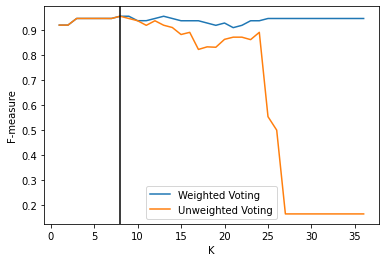

In [ ]:
# Optimizing KNN hyperparameters
k_values = range(1, y_train.size)
weighted_voting_bools = [True, False]
f_scores = [[], []]

params_to_f = {}
for k in k_values:
  for i, weighted_voting in enumerate(weighted_voting_bools):
    y_pred = np.array([predict(i, K=k, weighted_voting=weighted_voting) for i in range(y_test.size)])
    f_measure = f1_score(y_pred, y_test, average="macro")
    f_scores[i].append(f_measure)
    params_to_f[(k, weighted_voting)] = f_measure

(best_k, best_weighted), best_f = max(params_to_f.items(), key=lambda x: x[1])

plt.plot(k_values, f_scores[0], label='Weighted Voting')
plt.plot(k_values, f_scores[1], label='Unweighted Voting')
plt.axvline(best_k, c='k')
plt.xlabel('K')
plt.ylabel('F-measure')
plt.legend()
plt.show()

We've optimized performance exhaustively iterating over all the possible input parameters. This exhaustive approach is called a **parameter sweep**, or a **grid search**.

##Running Grid Search

Scikit-Learn has a built-in model for running KNN classification. 

In [ ]:
# Printing the preset KNN parameters
clf = KNeighborsClassifier()
K = clf.n_neighbors
weighted_voting = clf.weights

print(f"K is set to {K}.")
print(f"Weighted voting is set to `{weighted_voting}`.")

K is set to 5.
Weighted voting is set to `uniform`.


We can reinitialize `clf` with custom parameters.

In [ ]:
# Setting Scikit-Learn’s KNN parameters
clf = KNeighborsClassifier(n_neighbors=4, weights="distance")
assert clf.n_neighbors == 4
assert clf.weights == "distance"

Now, we'll want to train our KNN model. Any Scikit-Learn `clf` classifier can be trained using the `fit` method.

In [ ]:
# Training Scikit-Learn’s KNN classifier
clf.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=4, weights='distance')

After training, `clf` can predict the classes of any input `X_test` matrix (whose dimensions match `X_train`). 

Predictions are carried out with the `clf.predict` method.

In [ ]:
# Predicting classes with a trained KNN classifier
y_pred = clf.predict(x_test)
f_measure = f1_score(y_pred, y_test, average="macro")

print(f"The predicted classes are:\n{y_pred}")
print(f"The actual classes are:\n{y_test}")
print(f"\nThe f-measure equals {f_measure:.2f}.")

The predicted classes are:
[2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 2 1 0 0 2 0 0 1 1 0 2 1 0 2 2 1 0
 2 1 1 2 0 2 0 0 1 2 2 1 2 1 2 1 1 1 1 1 1 1 2 1 0 2 1 1 1 1 2 0 0 2 1 0 0
 1 0 2 1 0 1 2 1 0 2 2 2 2 0 0 2 2 0 2 0 2 2 0 0 2 0 0 0 1 2 2 0 0 0 1 1 0
 0 1]
The actual classes are:
[2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 2 1 0 0 2 0 0 1 1 0 2 1 0 2 2 1 0
 1 1 1 2 0 2 0 0 1 2 2 2 2 1 2 1 1 2 2 2 2 1 2 1 0 2 1 1 1 1 2 0 0 2 1 0 0
 1 0 2 1 0 1 2 1 0 2 2 2 2 0 0 2 2 0 2 0 2 2 0 0 2 0 0 0 1 2 2 0 0 0 1 1 0
 0 1]

The f-measure equals 0.95.


Additionally, `clf` allows to extract more nuanced prediction output. 

For instance, we can generate the fraction of the votes received by class for an inputted sample in `X_test`.


In [ ]:
# Outputting vote ratios for each class
vote_ratios = clf.predict_proba(x_test)
print(vote_ratios[:4])

[[0.         0.21419074 0.78580926]
 [0.         1.         0.        ]
 [1.         0.         0.        ]
 [0.         0.         1.        ]]


Now, lets turn our attention to running grid search across `KNeighborsClassifier`. 

First we'll need to specify a dictionary mapping between our hyperparameters and their value-ranges.

In [ ]:
# Defining a hyperparameter dictionary
hyperparams = {
    "n_neighbors": range(1, 40),
    "weights": ["uniform", "distance"]
}

In [ ]:
#  Initializing Scikit-Learn’s grid search class
clf_grid = GridSearchCV(KNeighborsClassifier(), hyperparams, scoring="f1_macro")

In [ ]:
# Running a grid search 
clf_grid.fit(X, y)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 40),
                         'weights': ['uniform', 'distance']},
             scoring='f1_macro')

We've executed the grid-search. The optimized hyperparameters are stored within the `clf_grid.best_params_` attribute. 

Likewise, the f-measure associated with these parameters is stored within `clf_grid.best_score_`.

In [ ]:
# Checking the optimized grid search results
best_f = clf_grid.best_score_
best_params = clf_grid.best_params_
print(f"A maximum f-measure of {best_f:.2f} is achieved with the following hyperparameters:\n{best_params}")

A maximum f-measure of 0.99 is achieved with the following hyperparameters:
{'n_neighbors': 10, 'weights': 'distance'}


The optimized KNN classifier is stored within the `clf_grid.best_estimator_` attribute.

In [ ]:
# Accessing the optimized classifier
clf_best = clf_grid.best_estimator_

assert clf_best.n_neighbors == best_params["n_neighbors"]
assert clf_best.weights == best_params["weights"]

By leveraging `clf_best`, we can carry out predictions on new data. 

Alternatively, we can carry-out predictions directly with our optimized `clf_grid` object, by running `clf_grid.predict`.

In [ ]:
# Generating predictions with `clf_grid`
assert np.array_equal(clf_grid.predict(X), clf_best.predict(X))

##KNN Algorithm Limitations

The biggest problem with KNN is its speed. The algorithm can be very slow to run when the training set is large.

We'll illustrate this slow-down by increasing elements within our training set `(X, y)` by 2000-fold. Afterwards, we'll time the grid-search process for the expanded data. 

**The code will take approximately 15 mintues to run. Hence, it has been commented out.**

In [ ]:
# Optimizing KNN on a large training set
X_large = np.vstack([X for _ in range(2000)])
y_large = np.hstack([y for _ in range(2000)])
clf_grid = GridSearchCV(KNeighborsClassifier(), hyperparams, scoring='f1_macro')

start_time = time.time()
clf_grid.fit(X_large, y_large)
running_time = (time.time() - start_time) / 60

print(f"The grid search took {running_time:.2f} minutes to run.")

The grid search took 24.66 minutes to run.
